In [28]:
#import libraries
import pandas as pd    
import numpy as np
import nltk
import csv
import io
import sklearn
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
import json
import math
import sklearn.cluster as sk
from collections import Counter
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import wordcloud
from PIL import Image
import math
import random
from scraping import *
from KMeans import *
from KMeans_map_reduce import *
from first_part_functions import*
from Hash_functions import *

# 1) Does basic house information reflect house's description?

In this first section, it is performed a clustering analysis of house announcements in Rome from [Immobiliare.it](https://www.immobiliare.it/). It will be implemented two clusterings with the data scrapped from the mentioned website and the results obtained will be compared in order to look for similarity.

### Scraping

A dataset is created retreving at least 10000 announcements from *Immobiliare.it*. The dataset created from scraping the website has the following columns for each announcement:

In [2]:
#show format of the dataset created from scrapping the website
pd.DataFrame(columns=['title', 'description','price','locali','bagni','piano'])

,title,description,price,locali,bagni,piano


In [ ]:
#function to scrap the website Immobiliare.it and generate dataset
scraping()

Then, the dataset created is stored in a dataframe.

In [11]:
#read dataset
df = pd.read_csv(r'data.csv')

## Datasets

###  1) Information

Below it is created an information matrix, which has the following format: 
\begin{equation}
m_{ij} = value \quad \quad i \in \{announcement_1, ..., announcement_n\}\quad ,\quad j \in \{price, locali, superficie, bagni, piano \} 
\end{equation}
where $n$ is the number of the announcements. 
 
The announcements which do not have all the fields mentioned above are not considered. Besides, there are also accomodations whose values for the variable $piano$ are *A*, *R*,*T* or *S* or entries with *prezzo* or *da* as value in the column $price$. The announcements with these terms are not considered neither since they are not numeric. This process is done using the function <code>data\_cleaning\_setting()</code>. Besides, in this function is also created a column called $title+description$. This column contains the title and description of each entry, which will be useful later when it is created the description matrix. 



In [13]:
#removing entries that contain not numeric values in the fields price, locali, superficie, bagni, piano 
#creates colums "title+description"
df=data_cleaning_setting(df)

Once it is obtained the dataframe with the desired announcements, it is created the information matrix, using the function <code>information_creation()</code>.

In [20]:
#creation of information matrix
matrix_1=information_matrix(df)

###  2) Description

Then, it is computed a description matrix which has the following format: 

\begin{equation}
m_{ij} = tfIdf_{ij} \quad \quad i \in \{announcement_1, ..., announcement_n\} \quad,\quad j \in \{word_1, ...,word_k\}  
\end{equation}

where $n$ is the number of the announcements and $k$ is the cardinality of the vocabulary. 

In order to do so, first it is created a <code>.txt</code> file with the vocabulary which contains the preprocessed text from the column $title+description$.

In [7]:
# creation of .txt file with vocabulary of the dataframe
vocabulary_creation(df)

In [14]:
#load file with vocabulary
op = open(r'vocabulary_prueba.txt', 'r', encoding="utf-8")
vocabulary= json.loads(op.read())
op.close()

Then, it is created a <code>.txt</code> file with the inverted index (without *Tf-Idf* coefficients) of the dataframe. 

In [9]:
# creation of .txt file with inverted_index (without Tf-Idf)
inverted_index_creation(df,vocabulary)

In [16]:
#load file with inverted index(without Tf-Idf)
op = open(r'inverted_index_prueba.txt', 'r', encoding="utf-8")
inverted_index= json.loads(op.read())
op.close()

Below, it is computed a <code>.txt</code> file with the inverted index with *Tf-Idf* coefficients.

In [12]:
# creation of .txt file with inverted index with Tf-Idf coefficients
inverted_index_2_creation(df,vocabulary,inverted_index)

In [17]:
# load inverted index with the Tf-Idf coefficients
op = open(r'inverted_index_2_prueba.txt', 'r', encoding="utf-8")
inverted_index_TfIdf= json.loads(op.read())
op.close()

Finally, the information matrix is created using the vocabulary and inverted index with *Tf-Idf* created previously. 

In [18]:
#creation of the description matrix
matrix_2=description_matrix(df,vocabulary, inverted_index_TfIdf)

## Clustering

The house announcements are clustered from the information and description matrices using the K-means++ method. This method is a variation of the K-means algorithm which tries to solve the problem that the final approximation found can be arbitrarily bad compared to the optimal clustering. This is done specifying a procedure to initialize the centroid before proceeding with the standard k-means optimization iterations. The K-means++ algorithm is implemented using the library <code>[sklearn.cluster](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.cluster)</code>.

In order to decide the number of clusters, it is used the Elbow-method. We have used this graphical method plotting in the x-axis the number of clusters $k$ and in the y-axis the sum of squared distances. With the aim of having another criteria to choose the appropiate number of clusters $k$ apart from a visual guess, which might sometimes be ambiguous, it is used the following procedure:

    "It is drawn a straight line from the first value in the x-axis to the last one. Then, it is calculated the distance from each point considered in the x-axis to the line which has been drawn. The point with the largest distance indicates the appropiate number of clusters."

An example of the procedure is depicted [here](https://media.licdn.com/dms/image/C4E12AQGtYzxZcksIkQ/article-inline_image-shrink_1500_2232/0?e=1549497600&v=beta&t=eigTSSTtF4eCpdTwl7ul9o7ej5DHTRy35wY3RG4cxhM).



Below, using the function <code>cluster_process()</code>, it is displayed the Elbow-method for the information matrix and also is printed the optimal number of clusters, which was obtained with the method described above.   

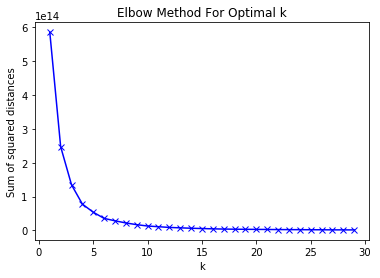

According to the Elbow-method, the optimal number of clusters is 4.


In [11]:
cluster_number=cluster_process(matrix_1)

Looking to the Elbow-method, it can be guessed that the optimal number of cluster is 4 since it is when the kink is poduced. This guess is confirmed with the procedure described above. Then, the K-means++ method is implemented for the information matrix with $k=4$.

In [23]:
#KMeans++ implemented for the information matrix with k=4
p = sk.KMeans(n_clusters=4).fit(matrix_1) 
n=pd.DataFrame(p.labels_)

The same procedure is repeated for the description matrix. Hovewer, this time the Elbow-method is not as effective as before to determine the number of clusters $k$. This is possibly for the big dimensions of the matrix and for the sparsity of the data. Apart from the fact that the convergence  to 0 of the sum of squared distances is very slow, there is not a clear kink in the graph which allows to make an appropiate visual guess. To implement the Elbow-method plot shown below this time has been used the values stored in a dictionary obtained from running the K-means++ algorithm several times. This is due to the fact, that the computation of the values was very time-comsuming for high values of $k$ for the description matrix and it has been done in different computers at the same time.

The method described before tell us that the optimal number of clusters is 1000 as it is shown in the plot below. However, this result does not seem appropiate since the description matrix contains about 3000 announcements, what would produce clusters with an average size of approximately 3. Besides, checking the similarity of clusters with such a big difference in size (information clusters vs description clusters) does not seem that will provide meaningful results. Anyway, the Jaccard-Similarity is computed later in order to verify this assumption.  

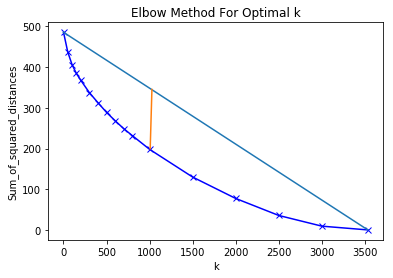

In [13]:
#Using dictionary to plot Elbow-method and show graphically the method described
values = {1: 485.59341082681885, 50: 437.23345598102685, 100: 406.08340967406986, 150: 384.51405978320065, 200:368.03215544791055, 300: 337.5789590205469, 400: 312.71376061287515,500: 288.83588253718705, 600: 268.2424362256976, 700: 248.7734070228772, 800: 231.58507909701765, 1000: 197.9766683366708, 1500: 129.83400810956954, 2000: 77.23689742740254, 2500:35.47372631066502, 3000: 9.22619571186973, 3533: 0}
l = list(values.values())
values
x = np.linspace(0, 3533, 1000)
y = np.linspace(1007, 1027, 1000)

distances = {}

p1 = Point(1,values[1])
p2 = Point(3533,values[3533])
#print(p2.X)
line = Line(p1,p2)

for i in values.keys():
    #print(i)
    p = Point(i+1,values[i])
    distances[i] = (line.distance(p))
    
distances.values()
plt.plot(list(values.keys()), l, 'bx-')
plt.plot(x, x*line.slope() - (line.c)/line.b)
plt.plot(y, -y*(1/(line.slope())) + (1/(line.slope()))*list(distances.keys())[list(distances.values()).index(max(distances.values()))] + max(distances.values()))
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Below it is implemented a function which computes the K-means++ algorithm for $k=1000$ and save the result in a <code>.csv </code> file. This is done to be able to provide the user a quick way to run the program, even though computing the  K-means++ algorithm different times provide not equal results. The  long computational time to obtain the result is due to the big dimensions of the description matrix and the chosen numbers of clusters. The result of this clustering will be compared to the one obtained from the information matrix later.

In [ ]:
#compute K-means++ method in description for k=1000 and save the result
create_save_clusters(k=1000,matrix=matrix_2)

In [21]:
#load result of K-means method for k=1000 
m=pd.read_csv('k1000.csv',header=None)

As it was said before $k=1000$ does not look as an appropiate number of clusters. That is the reason why it is chosen another value. As we want to compare how similar the clusters of the two matrix are, it seems logical to produce the same number of clusters and then check the similiraty of these to the clusters obtained from information matrix. Therefore, below it is computed the K-means++ algorithm for $k=4$ and the result is saved as in the last case.

In [15]:
#compute K-means++ method in description for k=4 and save the result
create_save_clusters(k=4,matrix=matrix_2)

In [22]:
s=pd.read_csv('k4.csv',header=None)

## Comparison among cluster


### Find similar clusters

We want to know how similar are the clusters produced from the information matrix to those obtained from the description matrix. 

In order to do so, it is used the Jaccard Similarity which is defined by the equation:

\begin{equation}
J(A,B)=\frac{|A\cap B|}{|A\cup B|}
\end{equation}
whose range of possible values is $[0,1]$ where $0$ is the lowest possible similarity and $1$ indicates the highest. In case that both sets are empty $J(A,B)=1$. 

First, it is shown the three most similar couples of clusters for the case where the description matrix were split in $1000$ clusters and their corresponding Jaccard Similarity.

In [17]:
#Returns dictionary(keys=couple of cluster;values=Jaccard similarity) and print it  
a=jaccard_similarities_combination(n,m)


The three most similar couples of cluster are:
Cluster 2(information matrix) and cluster 128(description matrix)  with a Jaccard similarity of 0.16878980891719744.
Cluster 3(information matrix) and cluster 175(description matrix)  with a Jaccard similarity of 0.16835147744945567.
Cluster 0(information matrix) and cluster 175(description matrix)  with a Jaccard similarity of 0.1556842867487328.


As it was expected the results are not very high. This is mostly produced for the difference in sizes of the clusters considered, since the Jaccard similarity takes into account the cardinality of the elements that are compared.

Below, it is computed the Jaccard similarity for the clusters created using the K-means++ algorithm with $k=4$ for both the information and the description matrix.

In [18]:
a=jaccard_similarities_combination(n,s)

The three most similar couples of cluster are:
Cluster 3(information matrix) and cluster 0(description matrix)  with a Jaccard similarity of 0.5254437869822485.
Cluster 0(information matrix) and cluster 0(description matrix)  with a Jaccard similarity of 0.26417004048583.
Cluster 3(information matrix) and cluster 3(description matrix)  with a Jaccard similarity of 0.16991869918699187.


In this case, the value for the Jaccard similarity for the couple of clusters is higher than before as it was supposed. In order to get more insights about the cluster produced for the K-means++ method is displayed the size of the clusters of the couples with highest Jaccard similarity.

In [19]:
#print size of the three most similar couples of clusters
y=cluster_dim(a,n,s)

There are 2327 observations in the cluster 3 (information matrix)  and 2829 observations in the cluster 0(description matrix).
There are 918 observations in the cluster 0 (information matrix)  and 2829 observations in the cluster 0(description matrix).
There are 2327 observations in the cluster 3 (information matrix)  and 551 observations in the cluster 3(description matrix).


It is true that it is obtained a bigger similirity considering $k=4$ for the information matrix instead of $k=1000$. Although the similarity is not extremely high, it might be regarded as a good result(above all for the first couple of cluster) if it is considered the difference in number of columns between the information and description matrix. This could be caused because each row of each matrices might contain similar information, in a numerical format (information matrix) or with words (description matrix).

## Word cloud of house descriptions


In this last section, it is created a wordcloud for each couple of clusters obtained before. The words that will be represented are those extracted from the description of the houses that are in the relative couple. In this visual representation the importance of each word is displayed with its font size. The bigger is a word, the more prominent the word is in that couple of clusters.

The wordcloud is displayed using the symbol of Immobiliare.it and its colours for the three couple of clusters.

In [20]:
#load image to produce the first cluster
house_mask= np.array(Image.open("def.png"))

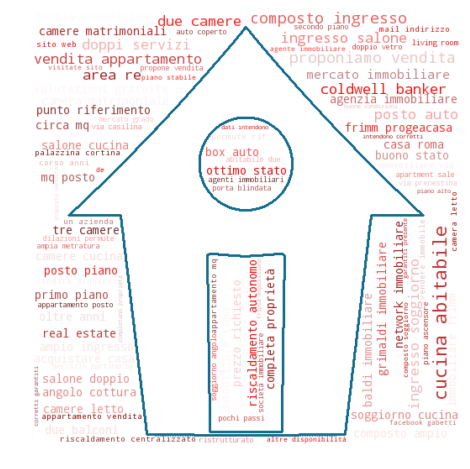

In [21]:
#wordcloud for the most similar couple of clusters
wordcloud_generator(s,n,y[0][0],y[1][0],house_mask,df)

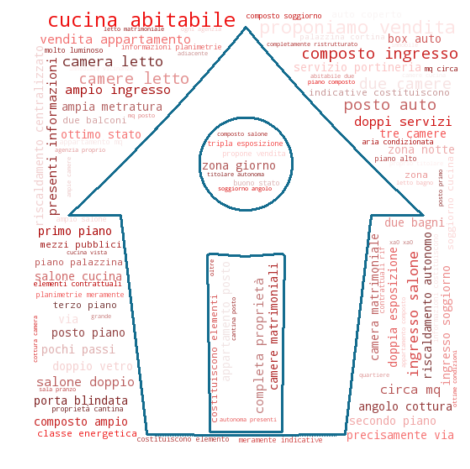

In [22]:
# wordcloud for the second most similar couple of clusters
wordcloud_generator(s,n,y[0][1],y[1][1],house_mask,df)

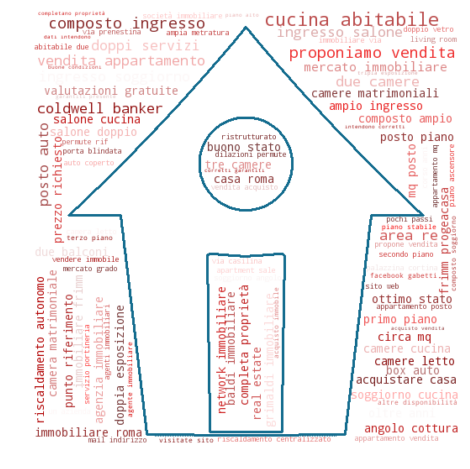

In [23]:
# wordcloud for the third most similar couple of clusters
wordcloud_generator(s,n,y[0][2],y[1][2],house_mask,df)

## Bonus clustering

### K-means algorithm

It has been implemented a class with K-means algorithm from scratch.In this case in constrast,to the K-Means++, it is produced a random initialisation. It is used to compute the clusters from the two previous matrices, and the results are compared to the one obtained with the K-means++. 

First, it is considered the information matrix. The clusters are computed using both methods:

In [30]:
#Computing clusters with both algorithms for the description matrix

l3=KMeans(matrix_1,4)
ph2 = sk.KMeans(n_clusters=4).fit(matrix_1)
#Creating dataframes from clusters
v=pd.DataFrame(ph2.labels_)
fli1=np.zeros([len(matrix_1)])
for i in l3.clustering:
    for j in l3.clustering[i]:
        fli1[j]=int(float(i))
fli1=fli1.astype(int) 
h=pd.DataFrame(fli1)


Then, the results printed. If the results are optimal, the four couples should be composed by different clusters since that will mean that one cluster from one method is equivalent to another of the other method.

In [31]:
c=cluster_comparison_1(v,h)

Comparisons of clusters:
Cluster 0(KMeans++) and cluster 0(KMeans)  with a Jaccard similarity of 0.9948696023941855.
Cluster 1(KMeans++) and cluster 1(KMeans)  with a Jaccard similarity of 0.9710610932475884.
Cluster 2(KMeans++) and cluster 2(KMeans)  with a Jaccard similarity of 0.9666666666666667.
Cluster 3(KMeans++) and cluster 3(KMeans)  with a Jaccard similarity of 0.9382239382239382.


It can be observed that the result printed is composed by four different couples of clusters and they have a high Jaccard similirality, what indicates that the results were quite similar.

Then it is done the same process with the clusters obtained from the description matrix. First, the clusterings using both methods are computed:

In [32]:
#Computing clusters with both algorithms for the information matrix
l6=KMeans(matrix_2,4)
ph4 = sk.KMeans(n_clusters=4).fit(matrix_2)
v2=pd.DataFrame(ph4.labels_)
fli2=np.zeros([len(matrix_2)])
for i in l6.clustering:
    for j in l6.clustering[i]:
        fli2[j]=int(float(i))
fli2=fli2.astype(int) 
h2=pd.DataFrame(fli2)


Then, the clusters are computed and the results printed:

In [33]:
#Printing results
c4=cluster_comparison_1(v2,h2)

Comparisons of clusters:
Cluster 0(KMeans++) and cluster 2(KMeans)  with a Jaccard similarity of 0.7596943107840363.
Cluster 2(KMeans++) and cluster 2(KMeans)  with a Jaccard similarity of 0.22076440387906446.
Cluster 1(KMeans++) and cluster 2(KMeans)  with a Jaccard similarity of 0.011123787792355962.
Cluster 0(KMeans++) and cluster 3(KMeans)  with a Jaccard similarity of 0.004057543341940244.


It can be seen that the four couples are not composed by different clusters. Besides, the Jaccard similarities obtained, except for the first one are low. Therefore, it can be seen differences between both methods.

### K-means with map reduce

It has been implemented class where it is computed the K-means algorithm using map reduce. In this case, this class is used to obtain the clusters for the information matrix and then the result is compared with the previous one. First, it is computed    the clusters with the K-Means++ method and the K-means with map reduce:

In [34]:
#Computing clusters with both algorithms for the information matrix
l10=KMeans_map_reduce(matrix_2,4)
ph10 = sk.KMeans(n_clusters=4).fit(matrix_2)
v3=pd.DataFrame(ph4.labels_)
fli3=np.zeros([len(matrix_2)])
for i in l10.clustering:
    for j in l10.clustering[i]:
        fli3[j]=int(float(i))
fli3=fli3.astype(int) 
h3=pd.DataFrame(fli3)

The results are printed below:

In [35]:
#Printing results
c2=cluster_comparison_1(v3,h3)

Comparisons of clusters:
Cluster 0(KMeans++) and cluster 0(KMeans)  with a Jaccard similarity of 0.7675537938844847.
Cluster 2(KMeans++) and cluster 0(KMeans)  with a Jaccard similarity of 0.21913929784824462.
Cluster 3(KMeans++) and cluster 3(KMeans)  with a Jaccard similarity of 0.1111111111111111.
Cluster 1(KMeans++) and cluster 0(KMeans)  with a Jaccard similarity of 0.011041902604756512.


It can be observed that even though the four couples are not composed by different clusters, the result of the best cluster is better than the one obtained before. 

# 2) Find the duplicates!

We register our results in a dictionary (key : hashNumber, value: number generated from the password) which is save as a json file. 

We import the functions createNumber_permutation, myHashF_permutation, createNumber_withoutPermutation and myHashF_withoutPermutation that are in the file functions.py

## Case : "AABA"="AAAB"

The goal is, from a password, to create a hash value which is calculated by a hash function that we made ourself. We want that our hash function generate the same value for 2 passwords which have the same characters (Ex : "AABA" and "AAAB"). Then we have to find the duplicates and the false positive.


We are calling createNumber_permutation which is use to onvert the list of ASCII to a number. The goal is to have the same number no matter the permutations. 
So if we have 2 password "ABC" and "ACB", the function generate the same number. So for that we are using

                            for x in listASCII : ∏(99 + (x-32))
We choose 99 because it's not too big soo the number is not too large and it's not too small to avoid colision. We remove 32 to our ASCII because the number from 0 to 32 of the ASCII table are not characters.

We are also calling myHashF_permutation which is used to hash our number. For this we are using a multiplication then a division. 
            
                            h(k) = (k*m)/a
where m is the maximum value that the hash function can create and a is the maximum value that we can have.

In [2]:
def main():
    dictN = {}
    FalsePositve = 0
    duplicate = 0
    filepw = open("passwords2.txt", 'r') # import file
    for i,pw in enumerate(filepw):
        pw = pw.replace('\n', '')
        #create our number from the list of ASCII(an element of the list correspond to the ASCII of a character of the password)
        number = createNumber_permutation([ord(c) for c in pw]) 
        # create the hashNumber from our number
        hashNumber = myHashF_permutation(number)
        if hashNumber in dictN:
            if number != dictN[hashNumber][-1]:
                # if the current number is different from the previous one and the hash values are the same
                FalsePositve +=1
            duplicate += 1
            dictN[hashNumber].append(number)
        else:
            dictN[hashNumber] = [number]
        if i < 10:
            print(pw + ' ' + str(number) + ' ' + str(hashNumber))
    with open('dict_hNb_pw.json', 'w') as fp:
        json.dump(dictN, fp)
    filepw.close()
    print("Number of false positive : " + str(FalsePositve))
    print("Number of duplicate found : " + str(duplicate-FalsePositve))
main()

OHcv-/U3QI$rdqYTef"D 15112737637330729907778267131053843415040000 498720296693
QtA*.xM$e(+"aO36r&Uo 4287811306126652810726836490120011736678400 141497760238
T;rqw/ou'HN-Pklj6hM* 25904910088876528033575884808393186017280000 854861955218
b%xJ79"A*C5@ehMfS3lu 8348767915565698645397323094791815168000000 275509316167
buI=;LpjBiCm"JS5'#xy 15957377812187419985608061076858784972800000 526593419930
cL=fhD1Vvu,4Gayn/UIX 26788093955511595911545847645165909442560000 884007020167
Q;b&2H<ST+yqC.4f"Ls, 4998846700973441301265497346944246432000000 164961926135
F'P/5m!:Qc=SX@W#Mkxi 7789852918436210831148592360587264000000000 257065122938
1ljfre*6Zy'"kIF4qzmp 32015340991943288937073590041791373230080000 1056506156688
w5EB>&J+)vdqPKaV1Z@j 11012248558756885696644337537631945932800000 363404169402
Number of false positive : 8462
Number of duplicate found : 9998672


Here the 10 first passwords with the numbers created from them and the hash values created from our numbers.

So we have 8462 false positive for all the passwords, this number can be imporve. For a good hash function this number should be 0. 

It also founds 9.998.672 duplicates.

## Case "AABA"!="AAAB"

Here the goal is the same but our hash function must generate a hash value for every passwords.


We are calling createNumber_withoutPermutation which is use to onvert the list of ASCII to a number. The goal is to have the same number no matter the permutations. 
So if we have 2 password "ABC" and "ACB", the function doesn't generate the same number. So we are just concatenate the ASCII value to which we remove 32 because the numbers from 0 to 32 of the ASCII table are not characters. 


We are also calling myHashF_withoutPermutation which is used to hash our number. For this we are using the division methode which is a modulo. 
            
                            h(k) = k mod m
where m is the maximum value that our hash function can create. Here we choose m = (2**32)-1 so our hash value is on 32bits.

In [3]:
def main():
    dictN = {}
    FalsePositve = 0
    duplicate = 0
    filepw = open("passwords2.txt", 'r') # import file
    for i,pw in enumerate(filepw):
        pw = pw.replace('\n', '')
        #create our number from the list of ASCII(an element of the list correspond to the ASCII of a character of the password)
        number = createNumber_withoutPermutation([ord(c) for c in pw]) 
        # create the hashNumber from our number
        hashNumber = myHashF_withoutPermutation(number)
        if hashNumber in dictN:
            if number != dictN[hashNumber][-1]:
                # if the current number is different from the previous one and the hash values are the same
                FalsePositve +=1
            duplicate += 1
            dictN[hashNumber].append(number)
        else:
            dictN[hashNumber] = [number]
        if i < 10:
            # print the 10 first passwords
            print(pw + ' ' + str(number) + ' ' + str(hashNumber))
    with open('dict_hNb_pw2.json', 'w') as fp:
        json.dump(dictN, fp)
    filepw.close()
    print("Number of false positive : " + str(FalsePositve))
    print("Number of duplicate found : " + str(duplicate-FalsePositve))
main()

OHcv-/U3QI$rdqYTef"D 47406786131553194941482688157526970236 4233562926
QtA*.xM$e(+"aO36r&Uo 498433101488454698112654719228265379 3283385464
T;rqw/ou'HN-Pklj6hM* 522782818715798574046134875767422724510 3417204550
b%xJ79"A*C5@ehMfS3lu 66588422325233103521326972457051197685 1138494995
buI=;LpjBiCm"JS5'#xy 6685412927448074347335772425121738889 2030939114
cL=fhD1Vvu,4Gayn/UIX 6744297072361754868512203965897815534156 3292929986
Q;b&2H<ST+yqC.4f"Ls, 49276661840285152118981351420702448312 1590679782
F'P/5m!:Qc=SX@W#Mkxi 3874815217712649672951563255345758873 3752584213
1ljfre*6Zy'"kIF4qzmp 17767470826910225889727541382081907780 3787480750
w5EB>&J+)vdqPKaV1Z@j 87213734306421198668814843655417583274 2770264149
Number of false positive : 1388118
Number of duplicate found : 4884418


Here the 10 first passwords with the numbers created from them and the hash values created from our numbers.

So we have 1.388.118 false positive for all the passwords, this number is not very good and can be improve. For a good hash function this number should be 0.

It also founds 4.884.418 duplicates.